In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [ ]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")
df_BOT= creator.reader("NF-BoT-IoT-v3")
df_CIC= creator.reader("NF-CICIDS2018-v3")

In [4]:
list_dfs = [df_UNSW, df_BOT, df_CIC]

df = pd.concat(list_dfs, ignore_index=True)
df = shuffle(df, random_state=42).reset_index(drop=True)
df.to_csv('db/concatenate.csv', index=False)

df_train, df_test, df_val = creator.splitter(df)

train_loader, test_loader, val_loader = creator.balancer(df_train, df_test, df_val)

Processando a categoria: 'Benign'
  -> Treino: 9902173 | Teste: 4951086 | Validação: 4951087
Processando a categoria: 'DoS'
  -> Treino: 4020085 | Teste: 2010042 | Validação: 2010043
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando a categoria: 'Reconnaissance'
  -> Treino: 856103 | Teste: 428051 | Validação: 428052
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'Infilteration'
  -> Treino: 94076 | Teste: 47038 | Validação: 47038
Processando a categoria: 'Bot'
  -> Treino: 103851 | Teste: 51926 | Validação: 51926
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino

In [9]:
df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [10]:
df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [11]:
df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [19]:
loader_names = ['UNSW', 'BOT', 'CIC', 'BOTH']
test_ids = [1, 2, 3, 4]
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC, test_loader]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [15]:
def train_model(model, train_loader, val_loader, epochs, weight1, weight2, lr, device, modelname, test, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs1 = model.forward_exit1(inputs)
            loss1 = criterion(outputs1, labels)
            
            outputs2 = model.forward_exit2(inputs)
            loss2 = criterion(outputs2, labels)
                
            total_loss = (weight1 * loss1) + (weight2 * loss2)

            total_loss.backward()
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs1 = model.forward_exit1(inputs)
                loss1 = criterion(outputs1, labels)
                
                outputs2 = model.forward_exit2(inputs)
                loss2 = criterion(outputs2, labels)
                    
                total_loss = (weight1 * loss1) + (weight2 * loss2)
                
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss/len(val_loader)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1} pois a loss de validação não melhora há {patience} épocas.')
            print(f'A melhor loss de validação foi: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'curve/testes/teste{test}/{modelname}.png')
    plt.show()

    return train_loss_history, val_loss_history

In [16]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    total_inference_time = 0

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            start_time = time.perf_counter()
            
            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            trusts, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = trusts > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            end_time = time.perf_counter()
            total_inference_time += (end_time - start_time)

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = 100 * correct / total_samples
    exit_rate = 100 * exited_early_count / total_samples
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples
        }

In [17]:
modelname = 'BOTH'

--- Training model: BOTH - Weight Exit 1: 0.7; Weight Exit 2: 0.3; Learning Rate: 0.0001
Epoch [1/150], Train Loss: 0.6881, Validation Loss: 0.6731
Epoch [2/150], Train Loss: 0.6635, Validation Loss: 0.6543
Epoch [3/150], Train Loss: 0.6544, Validation Loss: 0.6470
Epoch [4/150], Train Loss: 0.6491, Validation Loss: 0.6403
Epoch [5/150], Train Loss: 0.6435, Validation Loss: 0.6369
Epoch [6/150], Train Loss: 0.6386, Validation Loss: 0.6325
Epoch [7/150], Train Loss: 0.6327, Validation Loss: 0.6233
Epoch [8/150], Train Loss: 0.6277, Validation Loss: 0.6181
Epoch [9/150], Train Loss: 0.6213, Validation Loss: 0.6112
Epoch [10/150], Train Loss: 0.6160, Validation Loss: 0.6089
Epoch [11/150], Train Loss: 0.6117, Validation Loss: 0.6031
Epoch [12/150], Train Loss: 0.6050, Validation Loss: 0.5976
Epoch [13/150], Train Loss: 0.6020, Validation Loss: 0.5999
Epoch [14/150], Train Loss: 0.5973, Validation Loss: 0.6017
Epoch [15/150], Train Loss: 0.5932, Validation Loss: 0.5870
Epoch [16/150], Trai

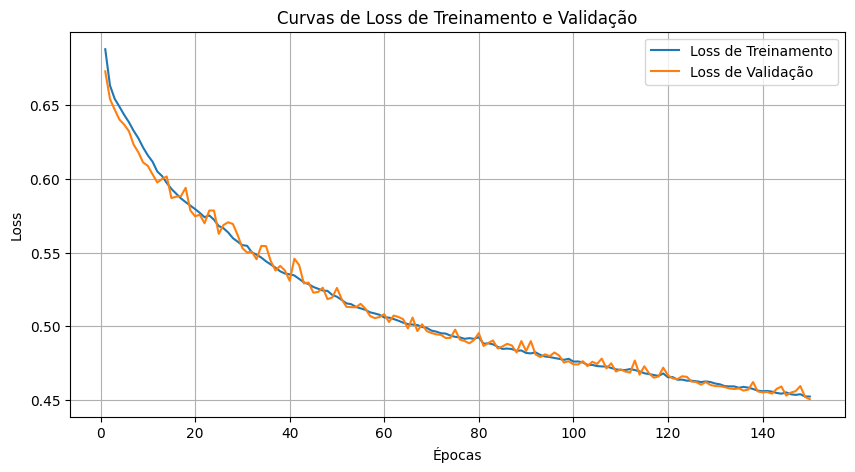

Model saved at 'models/teste1/BOTH.pth'

--- Training model: BOTH - Weight Exit 1: 0.7; Weight Exit 2: 0.3; Learning Rate: 1e-05
Epoch [1/150], Train Loss: 0.6954, Validation Loss: 0.6951
Epoch [2/150], Train Loss: 0.6948, Validation Loss: 0.6941
Epoch [3/150], Train Loss: 0.6935, Validation Loss: 0.6918
Epoch [4/150], Train Loss: 0.6906, Validation Loss: 0.6874
Epoch [5/150], Train Loss: 0.6851, Validation Loss: 0.6799
Epoch [6/150], Train Loss: 0.6773, Validation Loss: 0.6719
Epoch [7/150], Train Loss: 0.6706, Validation Loss: 0.6667
Epoch [8/150], Train Loss: 0.6670, Validation Loss: 0.6627
Epoch [9/150], Train Loss: 0.6647, Validation Loss: 0.6606
Epoch [10/150], Train Loss: 0.6628, Validation Loss: 0.6589
Epoch [11/150], Train Loss: 0.6617, Validation Loss: 0.6577
Epoch [12/150], Train Loss: 0.6604, Validation Loss: 0.6565
Epoch [13/150], Train Loss: 0.6594, Validation Loss: 0.6550
Epoch [14/150], Train Loss: 0.6588, Validation Loss: 0.6539
Epoch [15/150], Train Loss: 0.6578, Vali

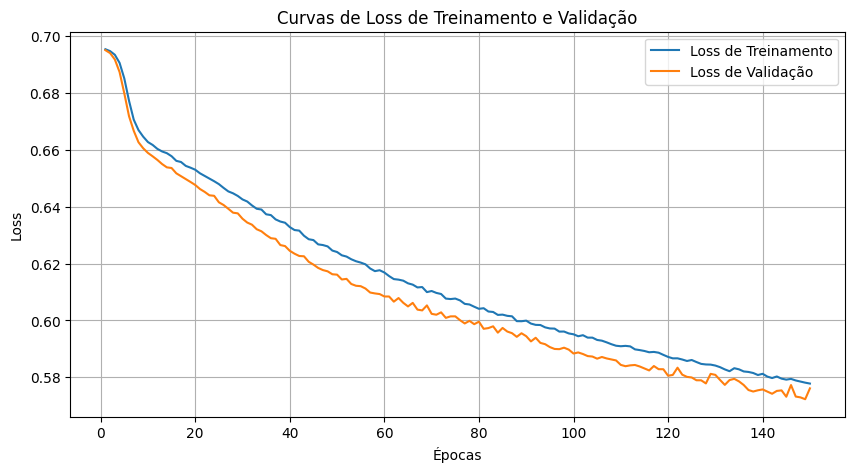

Model saved at 'models/teste2/BOTH.pth'

--- Training model: BOTH - Weight Exit 1: 0; Weight Exit 2: 1; Learning Rate: 0.0001
Epoch [1/150], Train Loss: 0.6762, Validation Loss: 0.6293
Epoch [2/150], Train Loss: 0.6025, Validation Loss: 0.5695
Epoch [3/150], Train Loss: 0.5764, Validation Loss: 0.5508
Epoch [4/150], Train Loss: 0.5558, Validation Loss: 0.5287
Epoch [5/150], Train Loss: 0.5359, Validation Loss: 0.5045
Epoch [6/150], Train Loss: 0.5216, Validation Loss: 0.5029
Epoch [7/150], Train Loss: 0.5056, Validation Loss: 0.4716
Epoch [8/150], Train Loss: 0.4872, Validation Loss: 0.4591
Epoch [9/150], Train Loss: 0.4759, Validation Loss: 0.4649
Epoch [10/150], Train Loss: 0.4665, Validation Loss: 0.4347
Epoch [11/150], Train Loss: 0.4519, Validation Loss: 0.4263
Epoch [12/150], Train Loss: 0.4395, Validation Loss: 0.4200
Epoch [13/150], Train Loss: 0.4346, Validation Loss: 0.4071
Epoch [14/150], Train Loss: 0.4253, Validation Loss: 0.4191
Epoch [15/150], Train Loss: 0.4177, Validat

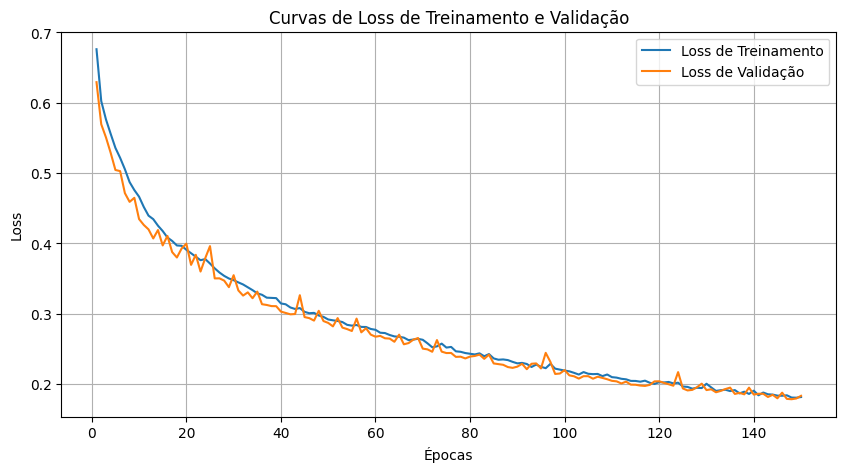

Model saved at 'models/teste3/BOTH.pth'

--- Training model: BOTH - Weight Exit 1: 0; Weight Exit 2: 1; Learning Rate: 1e-05
Epoch [1/150], Train Loss: 0.6928, Validation Loss: 0.6920
Epoch [2/150], Train Loss: 0.6916, Validation Loss: 0.6900
Epoch [3/150], Train Loss: 0.6891, Validation Loss: 0.6854
Epoch [4/150], Train Loss: 0.6830, Validation Loss: 0.6749
Epoch [5/150], Train Loss: 0.6698, Validation Loss: 0.6559
Epoch [6/150], Train Loss: 0.6485, Validation Loss: 0.6304
Epoch [7/150], Train Loss: 0.6253, Validation Loss: 0.6088
Epoch [8/150], Train Loss: 0.6089, Validation Loss: 0.5952
Epoch [9/150], Train Loss: 0.6002, Validation Loss: 0.5882
Epoch [10/150], Train Loss: 0.5953, Validation Loss: 0.5823
Epoch [11/150], Train Loss: 0.5905, Validation Loss: 0.5776
Epoch [12/150], Train Loss: 0.5865, Validation Loss: 0.5740
Epoch [13/150], Train Loss: 0.5818, Validation Loss: 0.5692
Epoch [14/150], Train Loss: 0.5790, Validation Loss: 0.5656
Epoch [15/150], Train Loss: 0.5759, Validati

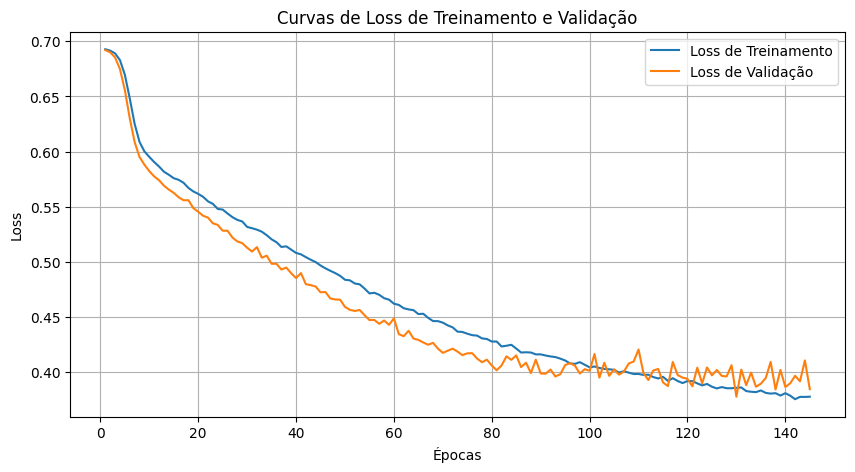

Model saved at 'models/teste4/BOTH.pth'



In [18]:
epochs = 150

for test in test_ids:
    model = IDSBranchyNet()
    
    if test < 3:
        weight1 = 0.7
        weight2 = 0.3
    else:
        weight1 = 0
        weight2 = 1

    if test % 2 != 0:
        lr = 0.0001
    else:
        lr = 0.00001
    
        
    print(f"--- Training model: {modelname} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}; Learning Rate: {lr}")
    
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs, weight1, weight2, lr, device=device, modelname=modelname, test=test)

    torch.save(model.state_dict(), f'models/teste{test}/{modelname}.pth')
    print(f"Model saved at 'models/teste{test}/{modelname}.pth'\n")
    

--- Model: BOTH | Loader: UNSW | TestID: 1 | Threshold: 0.8 ---
Model from: 'models/teste1/BOTH.pth' carregado


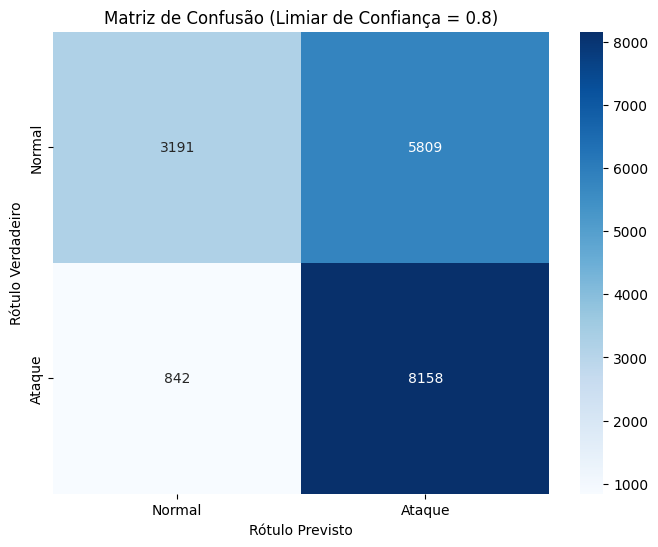

True Positives (TP): 8158
True Negatives (TN): 3191
False Positives (FP): 5809
False Negatives (FN): 842

F1 Score: 0.7104
True Positive Rate (TPR) / Recall: 0.9064
True Negative Rate (TNR) / Specificity: 0.3546
--------------------
Threshold: 0.8
  Accuracy: 63.05%
  Avg. Inference Time: 0.0176 ms
  Early Exit Rate: 7.71% (1388/18000)
--------------------


--- Model: BOTH | Loader: UNSW | TestID: 2 | Threshold: 0.8 ---
Model from: 'models/teste2/BOTH.pth' carregado


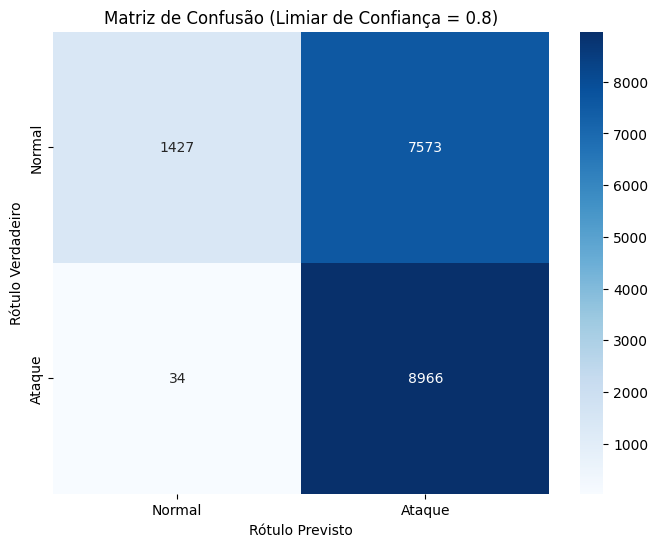

True Positives (TP): 8966
True Negatives (TN): 1427
False Positives (FP): 7573
False Negatives (FN): 34

F1 Score: 0.7021
True Positive Rate (TPR) / Recall: 0.9962
True Negative Rate (TNR) / Specificity: 0.1586
--------------------
Threshold: 0.8
  Accuracy: 57.74%
  Avg. Inference Time: 0.0021 ms
  Early Exit Rate: 0.00% (0/18000)
--------------------


--- Model: BOTH | Loader: UNSW | TestID: 3 | Threshold: 2.0 ---
Model from: 'models/teste3/BOTH.pth' carregado


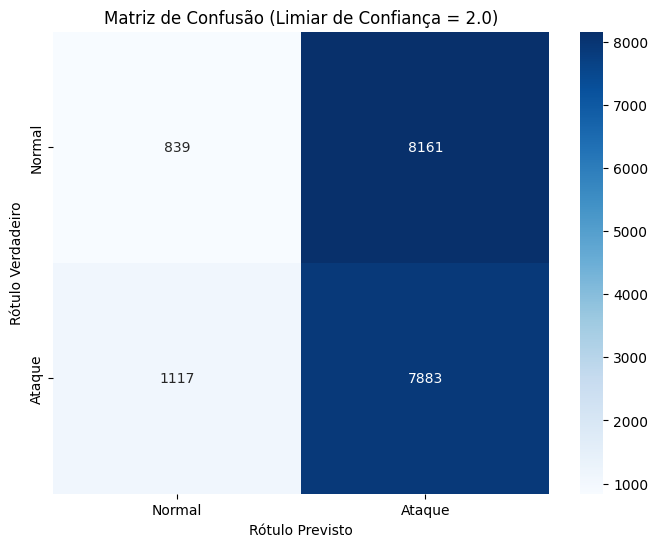

True Positives (TP): 7883
True Negatives (TN): 839
False Positives (FP): 8161
False Negatives (FN): 1117

F1 Score: 0.6295
True Positive Rate (TPR) / Recall: 0.8759
True Negative Rate (TNR) / Specificity: 0.0932
--------------------
Threshold: 2.0
  Accuracy: 48.46%
  Avg. Inference Time: 0.0022 ms
  Early Exit Rate: 0.00% (0/18000)
--------------------


--- Model: BOTH | Loader: UNSW | TestID: 4 | Threshold: 2.0 ---
Model from: 'models/teste4/BOTH.pth' carregado


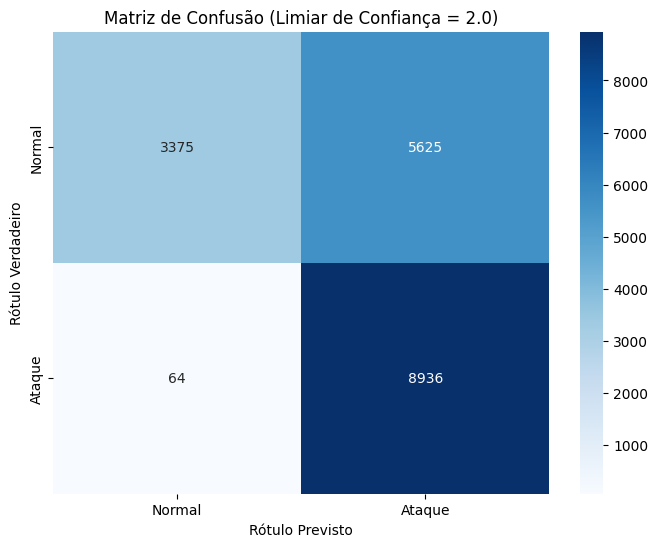

True Positives (TP): 8936
True Negatives (TN): 3375
False Positives (FP): 5625
False Negatives (FN): 64

F1 Score: 0.7585
True Positive Rate (TPR) / Recall: 0.9929
True Negative Rate (TNR) / Specificity: 0.3750
--------------------
Threshold: 2.0
  Accuracy: 68.39%
  Avg. Inference Time: 0.0021 ms
  Early Exit Rate: 0.00% (0/18000)
--------------------


--- Model: BOTH | Loader: BOT | TestID: 1 | Threshold: 0.8 ---
Model from: 'models/teste1/BOTH.pth' carregado


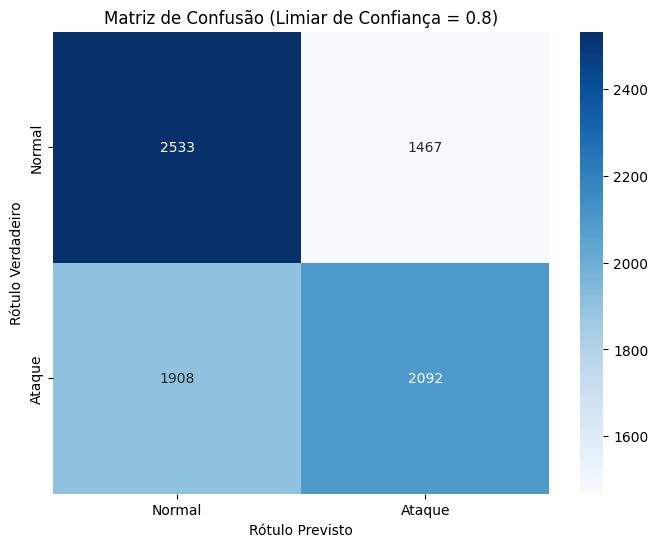

True Positives (TP): 2092
True Negatives (TN): 2533
False Positives (FP): 1467
False Negatives (FN): 1908

F1 Score: 0.5535
True Positive Rate (TPR) / Recall: 0.5230
True Negative Rate (TNR) / Specificity: 0.6332
--------------------
Threshold: 0.8
  Accuracy: 57.81%
  Avg. Inference Time: 0.0022 ms
  Early Exit Rate: 22.30% (1784/8000)
--------------------


--- Model: BOTH | Loader: BOT | TestID: 2 | Threshold: 0.8 ---
Model from: 'models/teste2/BOTH.pth' carregado


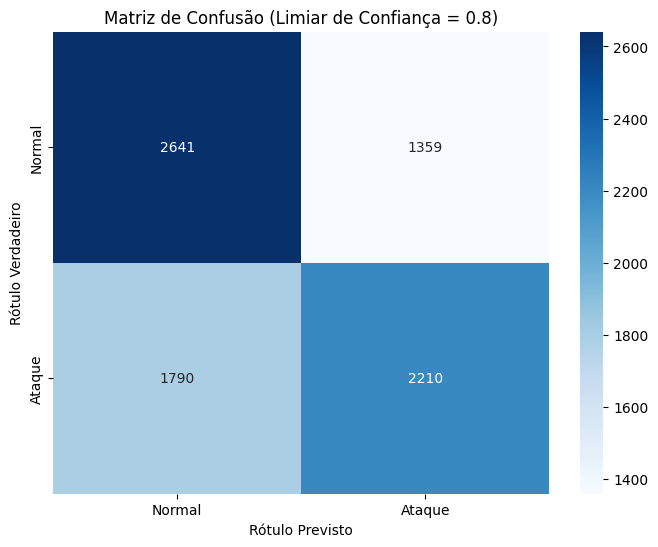

True Positives (TP): 2210
True Negatives (TN): 2641
False Positives (FP): 1359
False Negatives (FN): 1790

F1 Score: 0.5840
True Positive Rate (TPR) / Recall: 0.5525
True Negative Rate (TNR) / Specificity: 0.6603
--------------------
Threshold: 0.8
  Accuracy: 60.64%
  Avg. Inference Time: 0.0024 ms
  Early Exit Rate: 0.00% (0/8000)
--------------------


--- Model: BOTH | Loader: BOT | TestID: 3 | Threshold: 2.0 ---
Model from: 'models/teste3/BOTH.pth' carregado


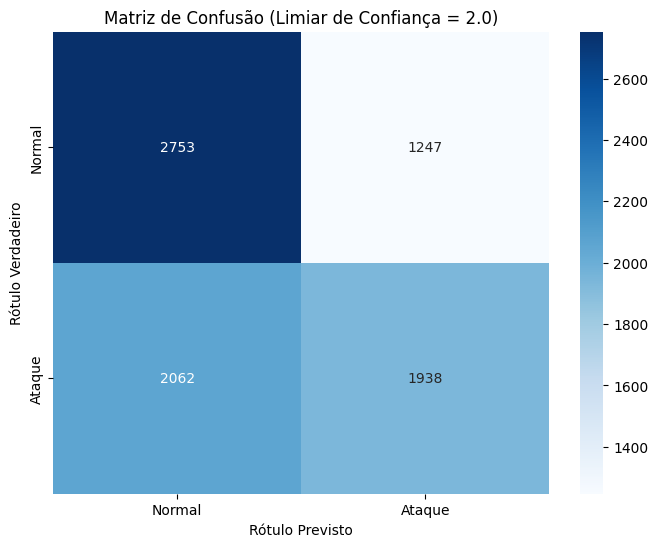

True Positives (TP): 1938
True Negatives (TN): 2753
False Positives (FP): 1247
False Negatives (FN): 2062

F1 Score: 0.5395
True Positive Rate (TPR) / Recall: 0.4845
True Negative Rate (TNR) / Specificity: 0.6883
--------------------
Threshold: 2.0
  Accuracy: 58.64%
  Avg. Inference Time: 0.0022 ms
  Early Exit Rate: 0.00% (0/8000)
--------------------


--- Model: BOTH | Loader: BOT | TestID: 4 | Threshold: 2.0 ---
Model from: 'models/teste4/BOTH.pth' carregado


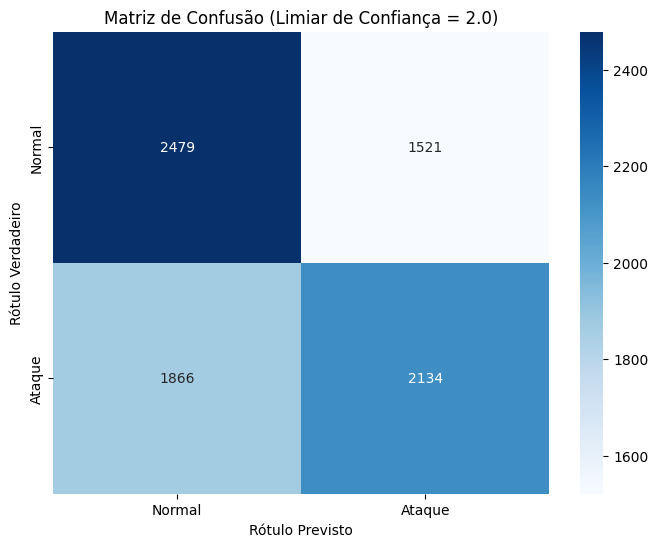

True Positives (TP): 2134
True Negatives (TN): 2479
False Positives (FP): 1521
False Negatives (FN): 1866

F1 Score: 0.5575
True Positive Rate (TPR) / Recall: 0.5335
True Negative Rate (TNR) / Specificity: 0.6198
--------------------
Threshold: 2.0
  Accuracy: 57.66%
  Avg. Inference Time: 0.0024 ms
  Early Exit Rate: 0.00% (0/8000)
--------------------


--- Model: BOTH | Loader: CIC | TestID: 1 | Threshold: 0.8 ---
Model from: 'models/teste1/BOTH.pth' carregado


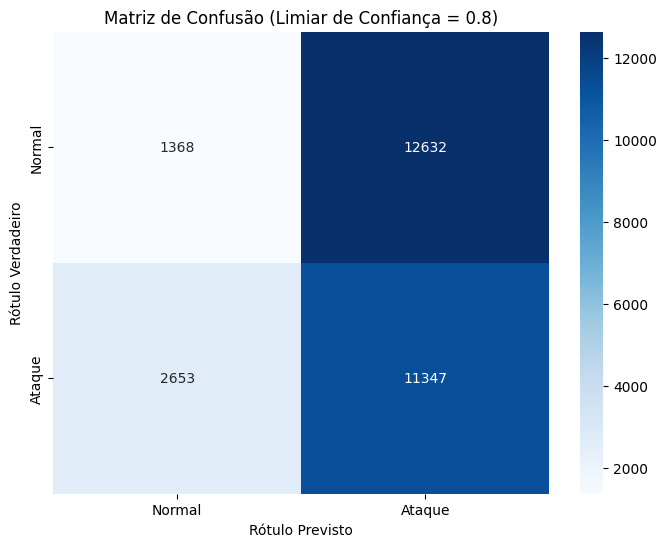

True Positives (TP): 11347
True Negatives (TN): 1368
False Positives (FP): 12632
False Negatives (FN): 2653

F1 Score: 0.5975
True Positive Rate (TPR) / Recall: 0.8105
True Negative Rate (TNR) / Specificity: 0.0977
--------------------
Threshold: 0.8
  Accuracy: 45.41%
  Avg. Inference Time: 0.0020 ms
  Early Exit Rate: 19.19% (5372/28000)
--------------------


--- Model: BOTH | Loader: CIC | TestID: 2 | Threshold: 0.8 ---
Model from: 'models/teste2/BOTH.pth' carregado


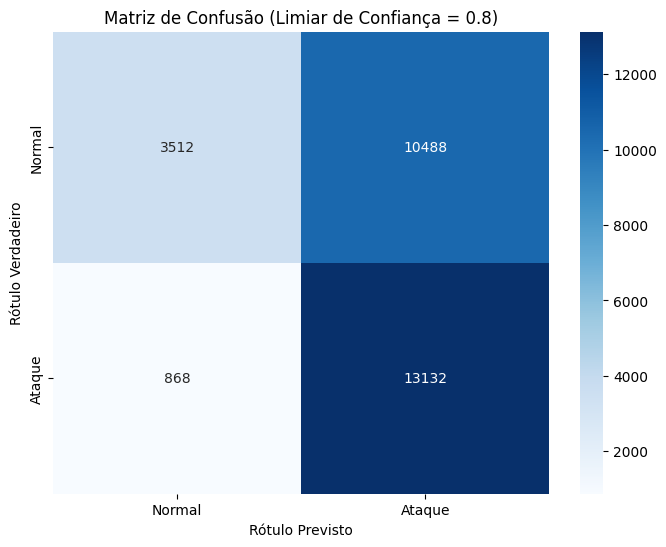

True Positives (TP): 13132
True Negatives (TN): 3512
False Positives (FP): 10488
False Negatives (FN): 868

F1 Score: 0.6981
True Positive Rate (TPR) / Recall: 0.9380
True Negative Rate (TNR) / Specificity: 0.2509
--------------------
Threshold: 0.8
  Accuracy: 59.44%
  Avg. Inference Time: 0.0022 ms
  Early Exit Rate: 0.00% (0/28000)
--------------------


--- Model: BOTH | Loader: CIC | TestID: 3 | Threshold: 2.0 ---
Model from: 'models/teste3/BOTH.pth' carregado


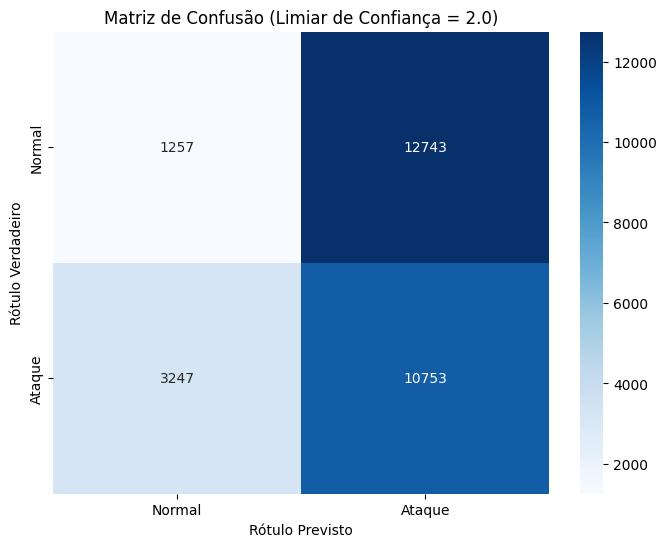

True Positives (TP): 10753
True Negatives (TN): 1257
False Positives (FP): 12743
False Negatives (FN): 3247

F1 Score: 0.5736
True Positive Rate (TPR) / Recall: 0.7681
True Negative Rate (TNR) / Specificity: 0.0898
--------------------
Threshold: 2.0
  Accuracy: 42.89%
  Avg. Inference Time: 0.0021 ms
  Early Exit Rate: 0.00% (0/28000)
--------------------


--- Model: BOTH | Loader: CIC | TestID: 4 | Threshold: 2.0 ---
Model from: 'models/teste4/BOTH.pth' carregado


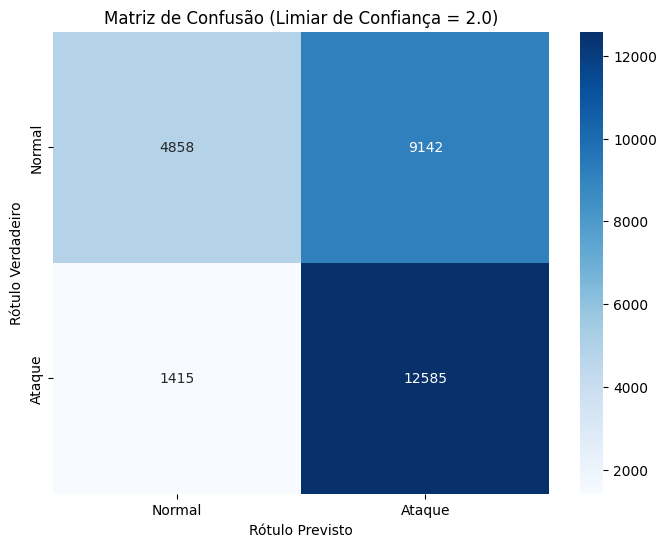

True Positives (TP): 12585
True Negatives (TN): 4858
False Positives (FP): 9142
False Negatives (FN): 1415

F1 Score: 0.7045
True Positive Rate (TPR) / Recall: 0.8989
True Negative Rate (TNR) / Specificity: 0.3470
--------------------
Threshold: 2.0
  Accuracy: 62.30%
  Avg. Inference Time: 0.0022 ms
  Early Exit Rate: 0.00% (0/28000)
--------------------


--- Model: BOTH | Loader: BOTH | TestID: 1 | Threshold: 0.8 ---
Model from: 'models/teste1/BOTH.pth' carregado


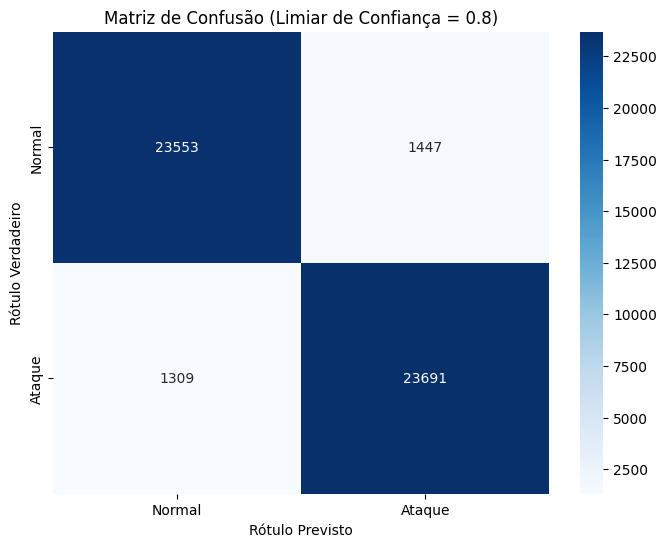

True Positives (TP): 23691
True Negatives (TN): 23553
False Positives (FP): 1447
False Negatives (FN): 1309

F1 Score: 0.9450
True Positive Rate (TPR) / Recall: 0.9476
True Negative Rate (TNR) / Specificity: 0.9421
--------------------
Threshold: 0.8
  Accuracy: 94.49%
  Avg. Inference Time: 0.0021 ms
  Early Exit Rate: 12.48% (6239/50000)
--------------------


--- Model: BOTH | Loader: BOTH | TestID: 2 | Threshold: 0.8 ---
Model from: 'models/teste2/BOTH.pth' carregado


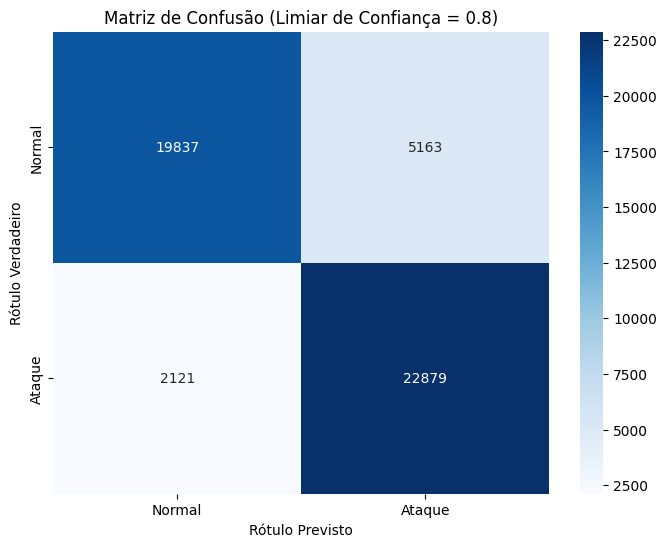

True Positives (TP): 22879
True Negatives (TN): 19837
False Positives (FP): 5163
False Negatives (FN): 2121

F1 Score: 0.8627
True Positive Rate (TPR) / Recall: 0.9152
True Negative Rate (TNR) / Specificity: 0.7935
--------------------
Threshold: 0.8
  Accuracy: 85.43%
  Avg. Inference Time: 0.0023 ms
  Early Exit Rate: 0.00% (0/50000)
--------------------


--- Model: BOTH | Loader: BOTH | TestID: 3 | Threshold: 2.0 ---
Model from: 'models/teste3/BOTH.pth' carregado


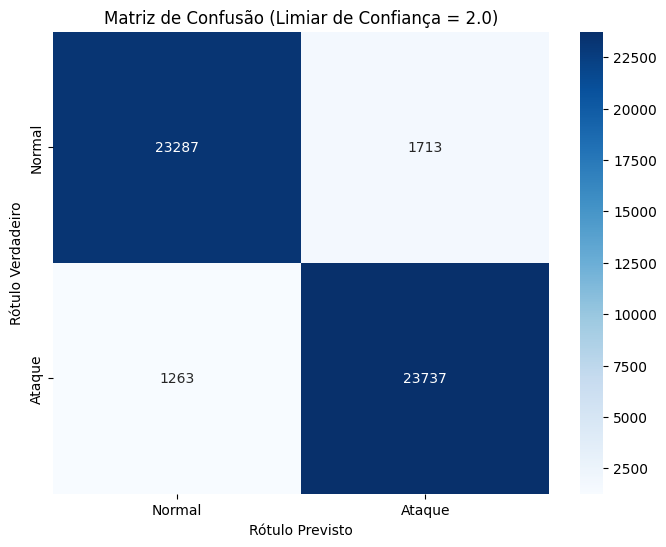

True Positives (TP): 23737
True Negatives (TN): 23287
False Positives (FP): 1713
False Negatives (FN): 1263

F1 Score: 0.9410
True Positive Rate (TPR) / Recall: 0.9495
True Negative Rate (TNR) / Specificity: 0.9315
--------------------
Threshold: 2.0
  Accuracy: 94.05%
  Avg. Inference Time: 0.0020 ms
  Early Exit Rate: 0.00% (0/50000)
--------------------


--- Model: BOTH | Loader: BOTH | TestID: 4 | Threshold: 2.0 ---
Model from: 'models/teste4/BOTH.pth' carregado


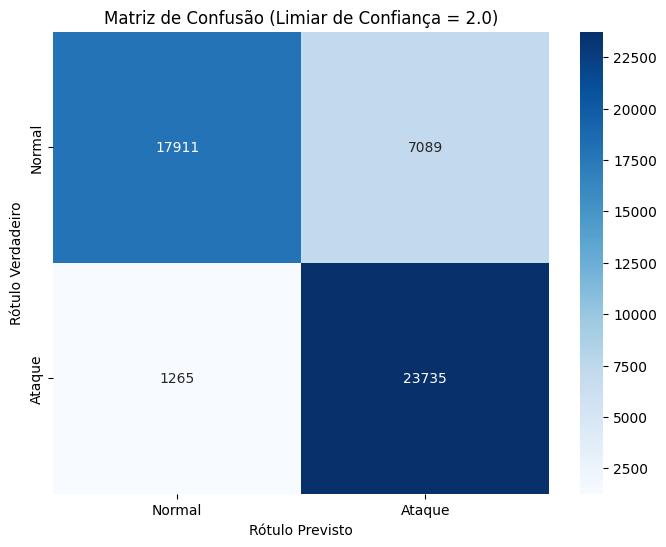

True Positives (TP): 23735
True Negatives (TN): 17911
False Positives (FP): 7089
False Negatives (FN): 1265

F1 Score: 0.8504
True Positive Rate (TPR) / Recall: 0.9494
True Negative Rate (TNR) / Specificity: 0.7164
--------------------
Threshold: 2.0
  Accuracy: 83.29%
  Avg. Inference Time: 0.0019 ms
  Early Exit Rate: 0.00% (0/50000)
--------------------




In [20]:
for loader in range(len(test_loaders)):
    for test in test_ids:
        if test < 3:
            T = 0.8
        else:
            T = 2.0

        print(f"--- Model: {modelname} | Loader: {loader_names[loader]} | TestID: {test} | Threshold: {T} ---")

        model.load_state_dict(torch.load(f'models/teste{test}/{modelname}.pth'))
        print(f"Model from: 'models/teste{test}/{modelname}.pth' carregado")

        results = evaluate_model(model, test_loaders[loader], confidence_threshold=T, device=device)
        print("-" * 20)
        print(f"Threshold: {T}")
        print(f"  Accuracy: {results['accuracy']:.2f}%")
        print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
        print(f"  Early Exit Rate: {results['exit_rate']:.2f}% ({results['exited_early_count']}/{results['total_samples']})")
        print("-" * 20)
        print("\n")